# Project Overview: Spam Detection using Longformer Embeddings and Genetic Algorithm

This project explores a methodology for spam detection utilizing advanced natural language processing techniques and a genetic algorithm for feature selection.

**Process and Methodology:**

*   **Data Loading and Preparation:** Load and prepare the email dataset, labeling emails as 'ham' (not spam) or 'spam'.
*   **Embedding Generation:** Utilize the Longformer pre-trained model to convert email text into high-dimensional numerical representations (embeddings), capturing semantic and contextual information.
*   **Genetic Algorithm for Feature Selection:** Employ a genetic algorithm to identify the most relevant subset of features from the Longformer embeddings. This multi-objective optimization balances classification performance with the number of selected features.
*   **Model Training and Evaluation:** Train a classification model (e.g., XGBoost) on the reduced set of features selected by the genetic algorithm. Evaluate the model's performance using standard metrics like accuracy, precision, recall, and F1-score.
*   **Analysis and Visualization:** Analyze the model's performance, visualize key aspects like feature importance and confusion matrix, and interpret the results.
*   **Prediction:** Implement functions to predict whether new, unseen text inputs are spam or not using the trained model and the selected features.

### Library and Module Imports

This cell imports all the necessary Python libraries and modules required for the entire notebook to run.

**Requirements/Dependencies:**
- These libraries need to be installed in your Python environment. In Google Colab, most of these are pre-installed.
- Specific versions might be required for certain functionalities, but the code should generally work with recent versions.

**Explanation:**
- Imports libraries for data manipulation (`pandas`, `numpy`).
- Imports libraries for visualization (`matplotlib.pyplot`, `seaborn`).
- Imports libraries for machine learning model building and evaluation (`sklearn`, `xgboost`).
- Imports libraries for working with pre-trained models (`torch`, `transformers`).
- Imports libraries for genetic algorithms (`deap`).
- Imports `tqdm` for progress bars.

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import torch
from deap import base, creator, tools, algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from transformers import LongformerTokenizer, LongformerModel
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Database setup
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL_proj/spam_assassin.csv")

df['label'] = df['target']

df = df[['text', 'label']]

texts = df['text'].astype(str).tolist()

labels = df['label'].astype(int).tolist()

df.head()

,text,label
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


### Embedding Generation

This cell:
- Loads the Longformer tokenizer and model.
- Defines a function `get_embedding` to convert text into a numerical representation (embedding) using the Longformer model.
- Applies the `get_embedding` function to all the text data.
- Stores the generated embeddings and original labels in NumPy arrays `X` and `y`.
- Prints the shape of the embeddings array.

In [ ]:
#### already obtained the embeddings, resource hungry task

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')

model.eval()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='longest', max_length=4096)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

embeddings = [get_embedding(t) for t in tqdm(texts)]

import numpy as np
X = np.array(embeddings)
y = np.array(labels)

print('Embeddings shape:', X.shape)

In [ ]:
# Load saved embeddings and labels
X = np.load('/content/drive/MyDrive/Colab Notebooks/DL_proj/longformer_embeddings.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/DL_proj/longformer_labels.npy')
# mask = np.load("/content/drive/MyDrive/Colab Notebooks/DL_proj/best_feature_mask.npy") # We will create this in the GA cell

print(X.shape, y.shape)

(5796, 768) (5796,)


In [ ]:
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
print("Model loaded successfully!")

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model loaded successfully!


In [ ]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.shape[1]
print("split complete")

split complete


### Genetic Algorithm Components Setup

This cell sets up the components for a genetic algorithm (GA) using the DEAP library:
- `creator.create('FitnessMax', base.Fitness, weights=(1.0, -1.0))`: Creates a fitness function named 'FitnessMax' that will be maximized for the first objective (model score) and minimized for the second objective (number of features).
- `creator.create('Individual', list, fitness=creator.FitnessMax)`: Creates an individual for the GA, which is a list (representing the feature mask) with the defined 'FitnessMax' fitness.
- `toolbox.register('attr_bool', lambda: random.choice([0, 1]))`: Registers a function to generate a boolean attribute (0 or 1) for each gene in the individual, representing whether a feature is selected or not.
- `toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, num_features)`: Registers a function to create an individual as a list of boolean attributes, with the length equal to the number of features.
- `toolbox.register('population', tools.initRepeat, list, toolbox.individual)`: Registers a function to create a population as a list of individuals.

In [ ]:
# GA components
# We set weights to (1.0, -1.0) to MAXIMIZE the score & minimise feature count

creator.create('FitnessMax', base.Fitness, weights=(1.0, -1.0))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('attr_bool', lambda: random.choice([0, 1]))  # Each feature can be on/off
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, num_features)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Genetic Algorithm Fitness and Operators

This cell:
- Defines the fitness evaluation function (`eval_fitness`) for the genetic algorithm.
- Takes an individual (a feature mask) as input.
- Selects the features based on the mask.
- Scales the selected features.
- Trains a Logistic Regression model using cross-validation.
- Returns the average cross-validation score (F1-weighted) and the ratio of selected features to the total number of features. These two values form the fitness tuple for the multi-objective optimization.
- Registers the evaluation function, as well as the crossover (`cxTwoPoint`), mutation (`mutFlipBit`), and selection (`selTournament`) operators with the GA toolbox.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

def eval_fitness(individual):
    mask = np.array(individual, dtype=bool)
    num_selected_features = np.sum(mask)

    if num_selected_features == 0:
        return 0.0, 0.0,

    X_train_sel = X_train[:, mask]

    scaler = StandardScaler()
    X_train_sel_scaled = scaler.fit_transform(X_train_sel)

    model = LogisticRegression(max_iter=500, solver='liblinear')

    try:
        # Use a more robust metric
        score = cross_val_score(model, X_train_sel_scaled, y_train,
                                cv=3,
                                scoring='f1_weighted',
                                n_jobs=-1).mean()
    except ValueError:
        return 0.0, 0.0,

    # Return the score- maximize and the feature count ratio- minimize

    return score, num_selected_features / num_features

# Register functions to toolbox
toolbox.register('evaluate', eval_fitness)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

### Genetic Algorithm Execution

This cell:
- Sets parameters for the genetic algorithm, like population size and number of generations.
- Initializes the population of potential feature masks.
- Uses a "Hall of Fame" to keep track of the best solution found so far.
- Runs the genetic algorithm (μ + λ algorithm) to evolve the population and find the best feature mask.
- Prints the best fitness achieved and the number of features selected by the best mask.
- Saves the best feature mask to a file.

In [ ]:
# genetic algorithm parameters
POP_SIZE = 20   # parent population size
LAMBDA = 20     # Lambda (number of offspring to produce each gen)
NGEN = 15
CXPB = 0.75     # Crossover probability
MUTPB = 0.2     # Mutation probability

population = toolbox.population(n=POP_SIZE)

# hall of fame stores the best individual found

hof = tools.HallOfFame(1)

# initial population

print("Evaluating initial population...")
fits = list(map(toolbox.evaluate, population))
for fit, ind in zip(fits, population):
    ind.fitness.values = fit

# Register best individual from initial pop
hof.update(population)

print(f"Starting evolution (μ={POP_SIZE}, λ={LAMBDA}) for {NGEN} generations...")

#uplus lambda algo

algorithms.eaMuPlusLambda(
    population,
    toolbox,
    mu=POP_SIZE,
    lambda_=LAMBDA,
    cxpb=CXPB,
    mutpb=MUTPB,
    ngen=NGEN,
    stats=None,
    halloffame=hof,
    verbose=True
)

print("\nEvolution complete.")

# obtain best individual
best_ind = hof[0]
print("\nBest fitness:", best_ind.fitness.values[0])
print(f"Number of features selected: {np.sum(best_ind)}")

file_path = "/content/drive/MyDrive/Colab Notebooks/DL_proj/best_feature_mask.npy"
np.save(file_path, mask)
print(f"Best feature mask saved to: {file_path}")

Evaluating initial population...
Starting evolution (μ=20, λ=20) for 15 generations...
gen	nevals
0  	0     
1  	19    
2  	19    
3  	20    
4  	19    
5  	19    
6  	20    
7  	20    
8  	19    
9  	19    
10 	19    
11 	19    
12 	20    
13 	20    
14 	19    
15 	18    

Evolution complete.

Best fitness: 0.996979533510857
Number of features selected: 387
Best feature mask saved.


### Model Training and Evaluation

This cell:
- Applies the feature mask obtained from the genetic algorithm to the training and testing datasets.
- Scales the selected features using `StandardScaler`.
- Trains an XGBoost classifier (`XGBClassifier`) on the scaled training data.
- Uses the scaled test data for early stopping during training.
- Evaluates the trained model on the test set.
- Prints the final test accuracy.

In [ ]:
# Apply the mask
X_train_sel = X_train[:, mask]
X_test_sel = X_test[:, mask]

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

print(f"Training XGBoost with {X_train_scaled.shape[1]} features selected by the GA.")

# XGBoost model
final_model = XGBClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=10,
    base_score=0.5
)

# We use the test set as the evaluation set for early stopping
final_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

print("Model training complete.")

# Eval on test set
preds = final_model.predict(X_test_scaled)

acc = accuracy_score(y_test, preds)
print(f"\nFinal Test Accuracy: {acc * 100:.2f}%")

Training XGBoost with 387 features selected by the GA.
Model training complete.

Final Test Accuracy: 99.22%


### Model Performance Metrics

This cell:
- Generates and prints a classification report for the trained XGBoost model.
- The report includes precision, recall, and F1-score for each class (ham and spam).
- It also prints the overall accuracy of the model on the test set.

In [ ]:

from sklearn.metrics import classification_report
import numpy as np

print("--- Model Performance Metrics ---")

try:
    print(f"Overall Accuracy: {acc * 100:.2f}%\n")

target_names = ['ham (Class 0)', 'spam (Class 1)']

try:
    report = classification_report(y_test, preds, target_names=target_names)
    print(report)



--- Model Performance Metrics ---
Overall Accuracy: 99.22%

                precision    recall  f1-score   support

 ham (Class 0)       0.99      1.00      0.99       779
spam (Class 1)       0.99      0.98      0.99       381

      accuracy                           0.99      1160
     macro avg       0.99      0.99      0.99      1160
  weighted avg       0.99      0.99      0.99      1160



### Confusion Matrix Visualization

This cell:
- Calculates and visualizes the confusion matrix for the XGBoost model's predictions on the test set.
- It displays both the raw counts and the percentages within each actual class.
- The heatmap provides a visual representation of how well the model is classifying ham and spam emails.

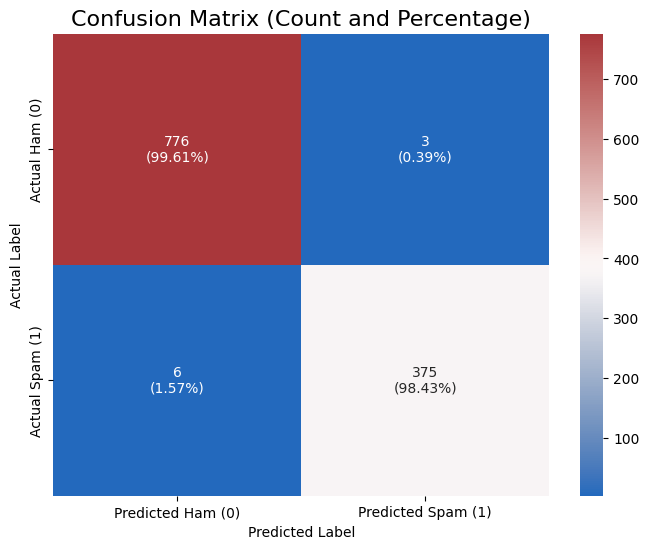

In [ ]:
try:
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create labels with both number and percentage

    labels = (
        np.asarray([
            f"{count}\n({percent:.2%})"
            for count, percent in zip(cm.flatten(), cm_percent.flatten())
        ])
    ).reshape(2, 2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=labels,
        fmt='',
        cmap='vlag',
        xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'],
        yticklabels=['Actual Ham (0)', 'Actual Spam (1)']
    )
    plt.title('Confusion Matrix (Count and Percentage)', fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


### Embedding Generation Function

This cell:
- Re-defines the `get_embedding` function, which takes a text input and returns its Longformer embedding.
- This is included again here for clarity or in case the previous definition was in a cell that was not executed in the current session.

In [ ]:
model.eval()

embedding generator

def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='longest', max_length=4096)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

### Prediction Function (by Index)

This cell defines a function `predict_from_embedding` that takes an index from the original dataset, retrieves its pre-computed embedding, applies the feature mask, scales the selected features, and then uses the trained XGBoost model (`final_model`) to predict the label and confidence score for that embedding. It demonstrates how to make a prediction on a single data point using its index.

In [ ]:
def predict_from_embedding(index):
    emb = X[index, mask].reshape(1, -1)

    # Scale the data using the scaler from the cell above
    emb_scaled = scaler.transform(emb)

    prob_array = final_model.predict_proba(emb_scaled)[0]
    pred = final_model.predict(emb_scaled)[0]

    confidence_score = prob_array[pred]

    print(f"Predicted Label: {pred}")
    print(f"Confidence: {confidence_score:.3f}")
    return pred, prob_array

# Example prediction
predict_from_embedding(25)

Predicted Label: 0
Confidence: 0.998


(np.int64(0), array([0.99775916, 0.00224083], dtype=float32))

### Prediction Function (by Text Input)

This cell defines a function `predict_text` that takes a raw text string as input. It generates the Longformer embedding for the text using the `get_embedding` function, applies the feature mask, scales the selected features, and then uses the trained XGBoost model to predict the label and confidence score for the text. This function allows for making predictions on new, unseen text data.

In [ ]:
def predict_text(text):
    emb = get_embedding(text)
    emb_sel = emb[mask].reshape(1, -1)

    # Scale the data
    emb_scaled = scaler.transform(emb_sel)

    # Use .predict_proba()
    prob_array = final_model.predict_proba(emb_scaled)[0]
    pred = final_model.predict(emb_scaled)[0]

    confidence_score = prob_array[pred]

    print(f"Predicted Label: {pred} (0=ham, 1=spam)")
    print(f"Confidence: {confidence_score:.3f}")
    return pred, prob_array

### Example Predictions

This cell demonstrates how to use the `predict_text` function to predict whether two example text strings are ham or spam. It tests one example that is clearly spam and another that is clearly ham, printing the predicted label and confidence score for each.

In [ ]:
# example

test_spam = "CLICK HERE to win a free prize, limited time offer just for you!"
print(f"Testing SPAM: '{test_spam}'")
predict_text(test_spam)
print("---")
test_ham = "Hi team, just checking in on the project status. Can you send me the report? Thanks"
print(f"Testing HAM: '{test_ham}'")
predict_text(test_ham)x

Testing SPAM: 'CLICK HERE to win a free prize, limited time offer just for you!'
Predicted Label: 1 (0=ham, 1=spam)
Confidence: 0.999
---
Testing HAM: 'Hi team, just checking in on the project status. Can you send me the report? Thanks'
Predicted Label: 0 (0=ham, 1=spam)
Confidence: 0.986


(np.int64(0), array([0.98611724, 0.01388276], dtype=float32))

### Global Feature Importance Visualization

This cell visualizes the global feature importance of the top 20 features selected by the genetic algorithm for the trained XGBoost model. It extracts the feature importances from the model, creates a DataFrame, and generates a bar plot showing the importance score for each of the top features. This helps in understanding which features contribute most to the model's predictions.

--- Plot 1: Global Feature Importance (Top 20) ---


/tmp/ipython-input-3016356667.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


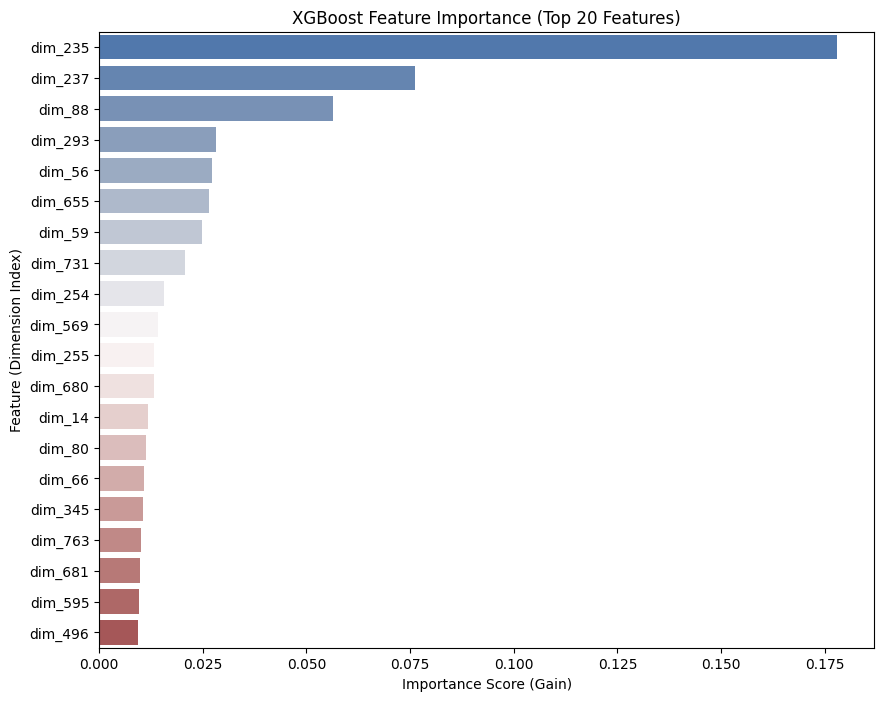

In [ ]:
print("--- Plot 1: Global Feature Importance (Top 20) ---")

feature_names = [f'dim_{i}' for i,v in enumerate(mask) if v]

importances = final_model.feature_importances_

# Dataframe of features
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.title("XGBoost Feature Importance (Top 20 Features)")
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(20),
    palette='vlag'
)
plt.xlabel("Importance Score (Gain)")
plt.ylabel("Feature (Dimension Index)")
plt.show()

### Correlation Heatmap of Top Features

This cell generates a correlation heatmap for the top 20 most important features identified by the XGBoost model. It extracts the scaled data for these features, calculates the correlation matrix, and visualizes it as a heatmap. This helps in understanding the relationships and potential collinearity between the most important features.


--- Plot 2: Correlation Heatmap of Top 20 Features ---


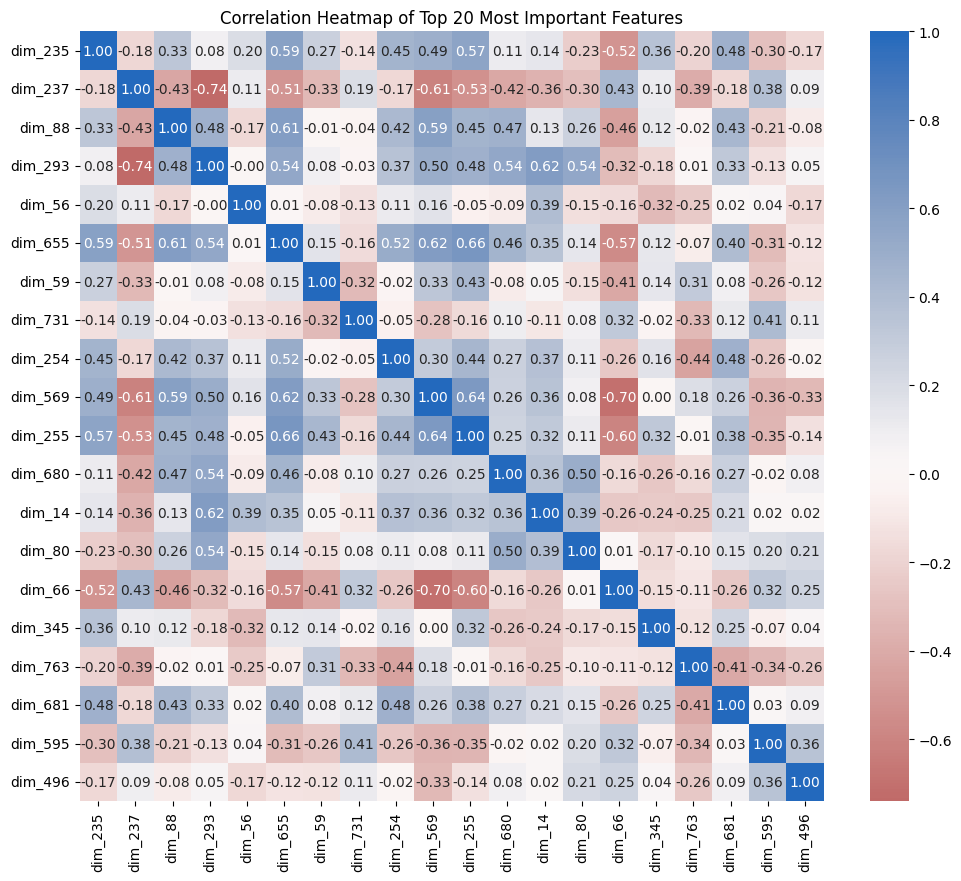

In [ ]:
print("\n--- Plot 2: Correlation Heatmap of Top 20 Features ---")

# top 20 features
top_20_features = feature_importance_df.head(20)['feature'].tolist()


top_20_indices = [int(f.replace('dim_', '')) for f in top_20_features]


original_indices_full = np.where(mask)[0]

index_map = {orig_idx: scaled_idx for scaled_idx, orig_idx in enumerate(original_indices_full)}

scaled_indices = [index_map[orig_idx] for orig_idx in top_20_indices]

top_features_df = pd.DataFrame(X_train_scaled[:, scaled_indices], columns=top_20_features)

corr_matrix = top_features_df.corr()

plt.figure(figsize=(12, 10))
plt.title("Correlation Heatmap of Top 20 Most Important Features")
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='vlag_r', center=0)
plt.show()